In [1]:
import pathlib
from IPython import display

import tensorflow as tf
from keras import models
from keras import layers

import numpy as np

from matplotlib import pyplot as plt

2024-04-30 23:10:01.260599: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 23:10:01.263342: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 23:10:01.300231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 23:10:02.001576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

DATASET_PATH: str = 'data/mini_speech_commands'

In [3]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.

    # signals: A[..., samples] float32 / float64 Tensor of real - valued signals.
    #
    # frame_length: An integer scalar Tensor.The window length in samples.

    # frame_step: An integer scalar Tensor.The number of samples to step.

    # fft_length: An integer scalar Tensor.The size of the FFT to apply. If not provided, uses the smallest power of
    # 2 enclosing frame_length.

    # window_fn: A callable that takes a window length and a dtype keyword argument and returns a[window_length]
    # Tensor of samples in the provided datatype.If set to None, no windowing is used

    # pad_end: Whether to pad the end of signals with zeros when the provided frame length and step produces a
    # frame that lies partially past its end.

    # name: An optional name for the operation.

    # 1. Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)

    # 2.  Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)

    #3. Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution
    # layers (which expect a shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [4]:
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="https://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.',
        cache_subdir='data')
    
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands, end='\n')

Commands: ['down' 'go' 'left' 'up' 'stop' 'right' 'yes' 'no']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("label names:", label_names)

print("sets 'commands' and 'labels' contain the same str values:", set(commands) == set(label_names))

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
sets 'commands' and 'labels' contain the same str values: True


In [6]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)  # single channel audio, drop the extra axis
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

#  Split a test dataset from the validation dataset
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

print(label_names[[1, 1, 3, 0]])

(64, 16000)
(64,)
['go' 'go' 'no' 'down']


2024-04-30 23:10:03.498142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


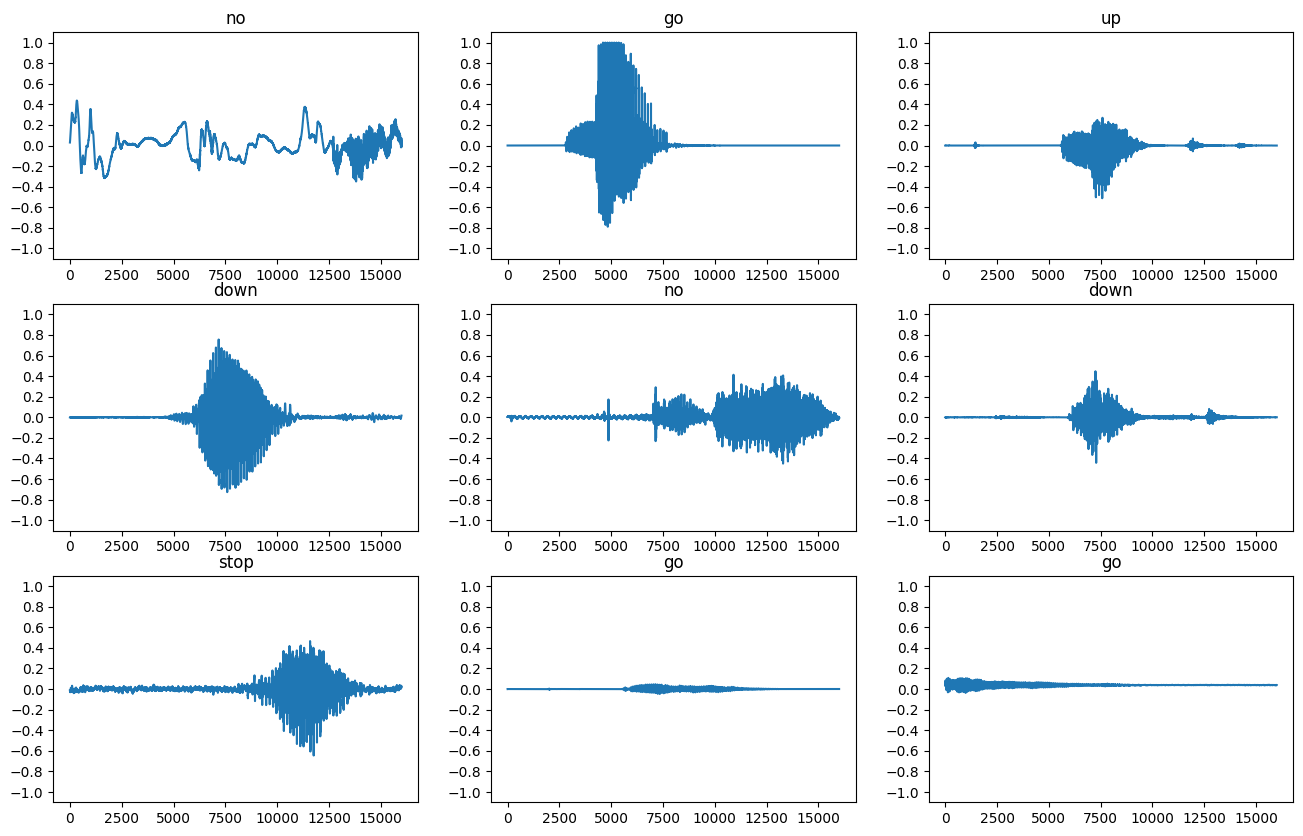

In [8]:
# plot labels (in steps of 1), and audio signal amplitude (-1.0 to 1.0) in TIME domain only

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()

In [9]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


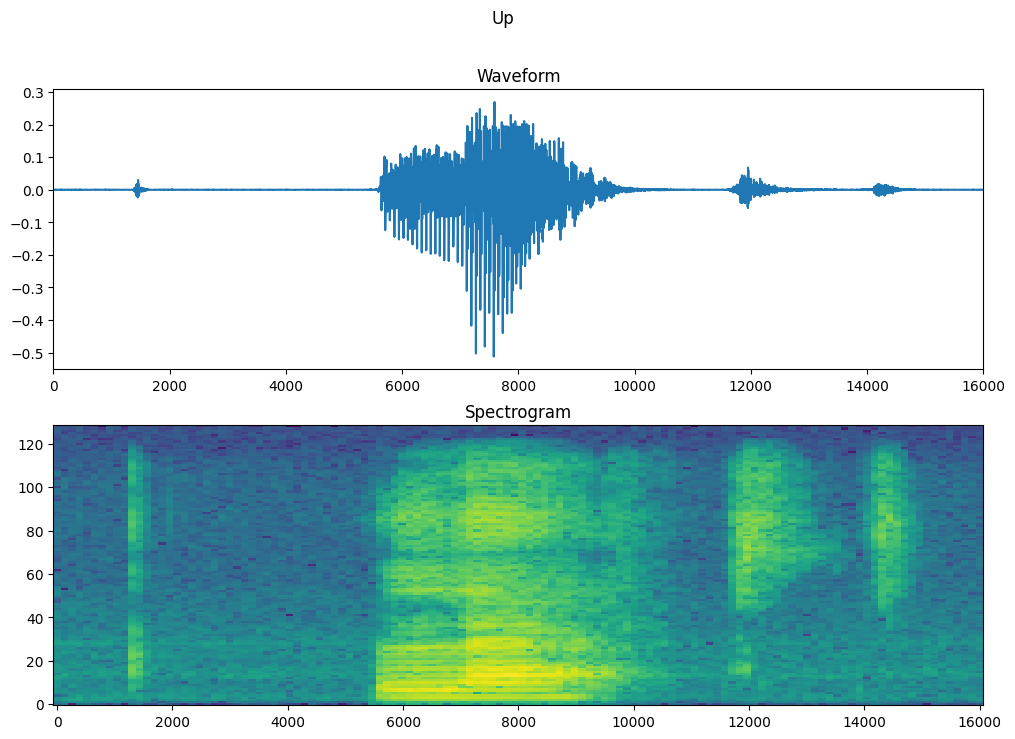

In [10]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [11]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


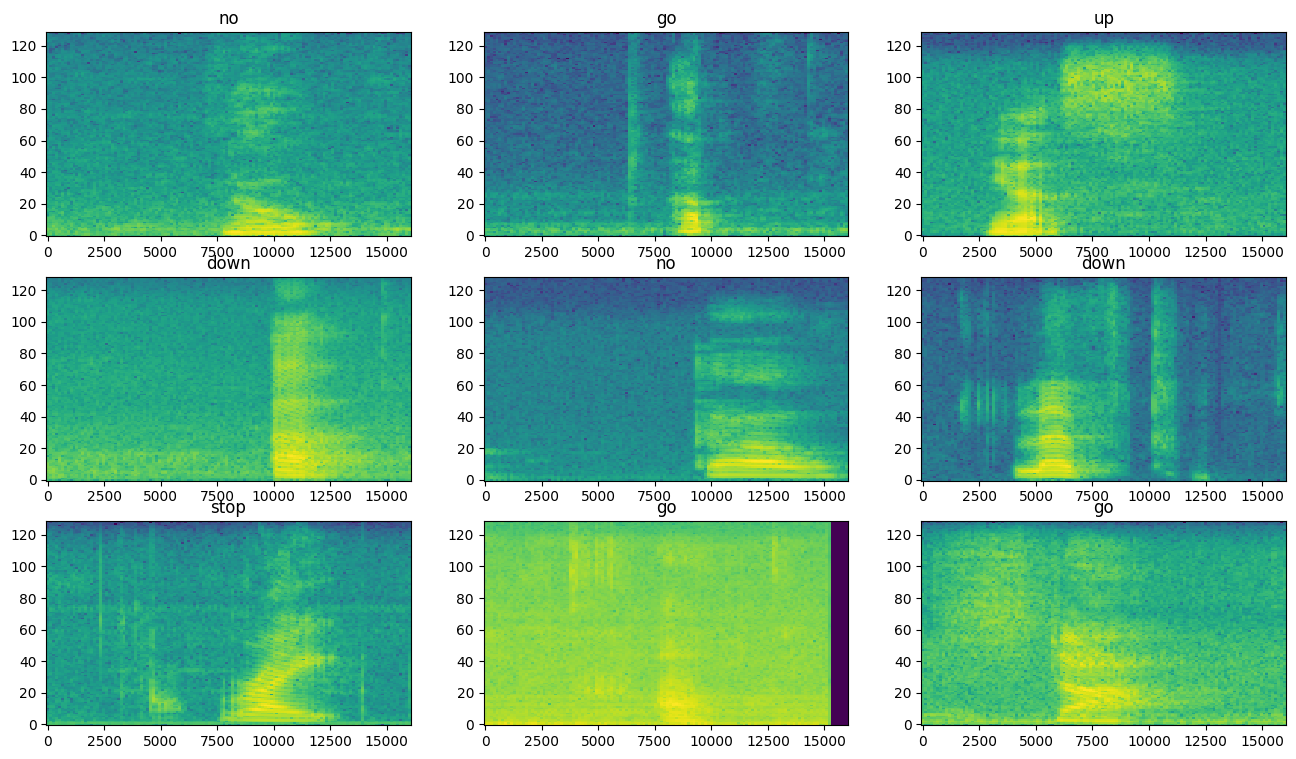

In [13]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-04-30 23:12:01.565980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 48, 48, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 48)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23232)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,973,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,123 (11.43 MB)

 Trainable params: 2,996,120 (11.43 MB)

 Non-trainable params: 3 (16.00 B)

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [19]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.1149 - loss: 2.0966 - val_accuracy: 0.1159 - val_loss: 2.0796
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.1224 - loss: 2.0796 - val_accuracy: 0.1094 - val_loss: 2.0843
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.1158 - loss: 2.0804 - val_accuracy: 0.1211 - val_loss: 2.0801
Epoch 3: early stopping


In [56]:
input_shape

TensorShape([124, 129, 1])